In [351]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.visualization import plot_histogram, plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere, plot_bloch_vector, plot_state_city, plot_bloch_multivector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit import assemble
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt 
from qiskit.providers.aer.noise import NoiseModel


In [337]:
#### Noise and gate noise
######
#Create gate with the bitflip error
######
def apply_err(n, err): #custum gate 
    qc = QuantumCircuit(int(n), name='Error')####! ad probability
    which_qubit = np.random.randint(n)
    
    if err=='bit':
        qc.x(which_qubit)
    elif err=='phase':
        qc.z(which_qubit)
    else:
        pass
    err = qc.to_gate()
    
    return err, which_qubit

err, which_qubit = apply_err(3, 'bit')

def get_noise(p, gate_name):
    basis_gate=gate_name
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel(basis_gate)
    noise_model.add_all_qubits_quantum_error(error_meas, gate_name) # measurement error is applied to measurements
    
    return noise_model
### Create the simulator




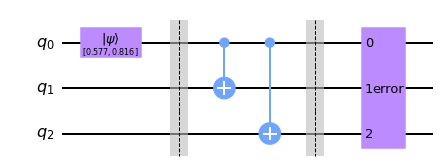

In [352]:
aer_sim = Aer.get_backend('aer_simulator')
import qiskit.quantum_info as qi
from qiskit.circuit import Gate
#error_gate = Gate(name='Error', num_qubits=3, params=[])
#Custum gate 
ident3 = qi.Operator([  [1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])
qe=QuantumCircuit(3,name='error')
qe.unitary(ident3, [0, 1, 2], label='error')
### Create the quantum circuit
qc_3qx = QuantumCircuit(3)
p_error = 0.7
initial_state = [1/np.sqrt(3), np.sqrt(2)/np.sqrt(3)]  
qc_3qx.initialize(initial_state, 0) # Initialize the 0th qubit in the state `initial_state`
qc_3qx.barrier()

###Encoding procedure
qc_3qx.cx(0,1)
qc_3qx.cx(0,2)
qc_3qx.barrier()
qc_3qx.append(qe,[0,1,2])
#qc_3qx.append(qe,[0,1,2])
#qc_3qx.append(qe,[0,1,2])
qc_3qx.draw('mpl')
plt.show()

In [353]:
'unitary' in AerSimulator().configuration().basis_gates
p_error=0.1
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
bit_flip1=bit_flip.tensor(bit_flip)
bit_flip2=bit_flip.tensor(bit_flip1)
print(bit_flip2)

QuantumError on 3 qubits. Noise circuits:
  P(0) = 0.001, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}, {'name': 'x', 'qubits': [2]}]
  P(1) = 0.009, QasmQobjInstructions = [[{'name': 'x', 'qubits': [1]}, {'name': 'x', 'qubits': [2]}]
  P(2) = 0.009, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [2]}]
  P(3) = 0.081, QasmQobjInstructions = [[{'name': 'x', 'qubits': [2]}]
  P(4) = 0.009000000000000001, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(5) = 0.081, QasmQobjInstructions = [[{'name': 'x', 'qubits': [1]}]
  P(6) = 0.081, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(7) = 0.729, QasmQobjInstructions = [[{'name': 'id', 'qubits': [2]}]


In [354]:

noise_model = NoiseModel(['unitary'])
noise_model.add_all_qubit_quantum_error(bit_flip2, 'error')
print(noise_model)

NoiseModel:
  Basis gates: ['unitary']
  Instructions with noise: ['error']
  All-qubits errors: ['error']


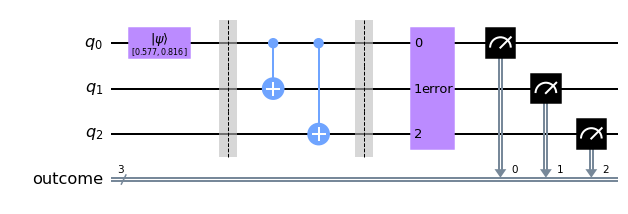

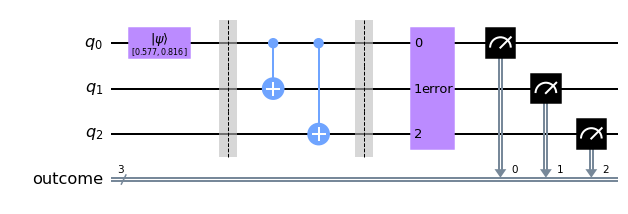

In [341]:
cr2=ClassicalRegister(3, 'outcome')
qc_3qx.add_register(cr2)
qc_3qx.measure([0,1,2],[0,1,2])
qc_3qx.draw('mpl')


{'011': 5615, '111': 48466, '100': 3237, '001': 3308, '110': 5744, '101': 5779, '010': 3351, '000': 24500}


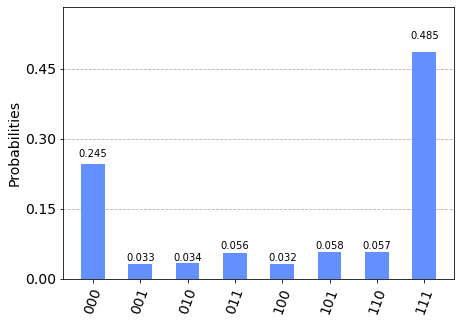

In [350]:
basis_gates = noise_model.basis_gates
qc_3qx.parameters
#print(AerSimulator().configuration().basis_gates)
result = execute(qc_3qx, Aer.get_backend('aer_simulator'),optimization_level=0,
                 noise_model=noise_model,shots=100000).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)
plt.show()

In [332]:

result = aer_sim.run(qc_3qx).result()
counts = result.get_counts()
plot_histogram(counts)
# counts=execute(qc_3qx,backend = aer_sim, noise_model=noise_model, shots=1000000).result().get_counts()
# plot_histogram(counts)
plt.show()

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {initialize, barrier, gate, measure}, "gates": {cx, error}} is not compatible with any of the automatic simulation methods


QiskitError: 'ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {initialize, barrier, gate, measure}, "gates": {cx, error}} is not compatible with any of the automatic simulation methods ,  ERROR: AerSimulator: circuit with instructions {"instructions": {initialize, barrier, gate, measure}, "gates": {cx, error}} is not compatible with any of the automatic simulation methods'

In [195]:
### Create the initial state \ket{\psi} (the information qubit)
initial_state = [1/np.sqrt(3), np.sqrt(2)/np.sqrt(3)]  
qc_3qx.initialize(initial_state, 0) # Initialize the 0th qubit in the state `initial_state`
qc_3qx.barrier()

###Encoding procedure
qc_3qx.cx(0,1)
qc_3qx.cx(0,2)
qc_3qx.barrier()

### Draw
#circuit_drawer(qc_3qx, output='mpl', fold=-1,style={'backgroundcolor': '#EEEEEE'},filename='my_circuit.png')
#plt.show()




###Plot on the q sphere
#qc_3qx.save_statevector()
#result = sim.run(transpile(qc_3qx, sim), shots=1000).result()
#psi  = result.get_statevector(qc_3qx)
#plot_state_qsphere(psi)
#plot_state_city(psi)
#plt.show()


##########
 #Define the error channel (still to do is implementing the probability)
##########


In [ ]:



#more general type of error

aer_sim = Aer.get_backend('aer_simulator')


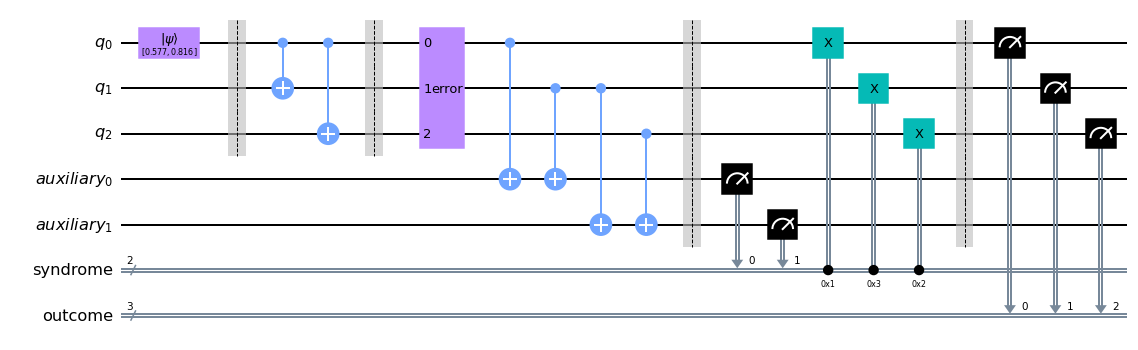

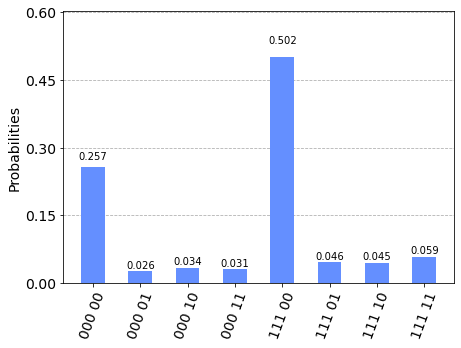

In [355]:

####Create the 3bi-flip error correction code 
#qc_3qx.append(err,range(3))
k=2
anc=QuantumRegister(k, 'auxiliary')
qc_3qx.add_register(anc)
cr=ClassicalRegister(k, 'syndrome')
qc_3qx.add_register(cr)
qc_3qx.cx(0,3)
qc_3qx.cx(1,3)
qc_3qx.cx(1,4)
qc_3qx.cx(2,4)
qc_3qx.barrier()
qc_3qx.measure(anc[0],cr[0])
qc_3qx.measure(anc[1],cr[1])

# ####Before error correction
# cr2=ClassicalRegister(3, 'outcome')
# qc_3qx.add_register(cr2)
# qc_3qx.measure([0,1,2],[2,3,4])
# qc_3qx.draw('mpl')
# counts=execute(qc_3qx,backend = sim, shots=1024).result().get_counts()
# plot_histogram(counts)
# plt.show()


###After error correction
qc_3qx.x(0).c_if(cr, 1)###condition is in binary
qc_3qx.x(1).c_if(cr, 3)
qc_3qx.x(2).c_if(cr, 2)
qc_3qx.barrier()
cr2=ClassicalRegister(3, 'outcome')
qc_3qx.add_register(cr2)
qc_3qx.measure([0,1,2],[2,3,4])
qc_3qx.draw('mpl')
counts=execute(qc_3qx,backend = aer_sim, noise_model= noise_model, shots=1024).result().get_counts()
plot_histogram(counts)
plt.show()